In [1]:
!nvidia-smi

Tue Mar 17 11:52:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!unzip /content/drive/'My Drive'/3rd-year-project/freiburg-forest.zip

Archive:  /content/drive/My Drive/3rd-year-project/freiburg-forest.zip
   creating: freiburg-forest/
   creating: freiburg-forest/train/
   creating: freiburg-forest/train/GT_color/
  inflating: freiburg-forest/train/GT_color/b290-499_mask.png  
  inflating: freiburg-forest/train/GT_color/b457-708_mask.png  
  inflating: freiburg-forest/train/GT_color/b109-006_mask.png  
  inflating: freiburg-forest/train/GT_color/b595-61_mask.png  
  inflating: freiburg-forest/train/GT_color/b269-993_mask.png  
  inflating: freiburg-forest/train/GT_color/b234-196_mask.png  
  inflating: freiburg-forest/train/GT_color/b391-909_mask.png  
  inflating: freiburg-forest/train/GT_color/b730-008_mask.png  
  inflating: freiburg-forest/train/GT_color/b103-904_mask.png  
  inflating: freiburg-forest/train/GT_color/b300-011_mask.png  
  inflating: freiburg-forest/train/GT_color/b131-451_mask.png  
  inflating: freiburg-forest/train/GT_color/b283-407_mask.png  
  inflating: freiburg-forest/train/GT_color/b371-45

In [0]:
# useful imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torch.utils.data
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms

import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preprocessing


In [0]:
import os
import glob
from PIL import Image, ImageOps
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, map_path, img_path, transform=None):
        super(CustomDataset, self).__init__()

        self.map_path = glob.glob(os.path.join(map_path, '*_mask.png'))
        
        self.img_path = [os.path.join(img_path, os.path.basename(fname)[:-9]+'_Clipped.jpg') for fname in self.map_path]

        transform_list = [transforms.ToTensor()]
        self.transform = transforms.Compose(transform_list)

    def __getitem__(self, index):
        label_map = Image.open(self.map_path[index])
        label_map = ImageOps.fit(label_map, (512, 256), Image.NEAREST)
        label_map = label_map.convert('RGB')
        label_map = self.transform(label_map)

        img = Image.open(self.img_path[index])
        img = ImageOps.fit(img, (512, 256), Image.NEAREST)
        img = img.convert('RGB')
        img = self.transform(img)
        
        return label_map, img
    
    def __len__(self):
        return len(self.img_path)

In [0]:
map_dir = 'freiburg-forest/train/GT_color/'
img_dir = 'freiburg-forest/train/rgb/'
batch_size = 1
dataset = CustomDataset(map_dir, img_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

map_dir_test = 'freiburg-forest/test/GT_color/'
img_dir_test = 'freiburg-forest/test/rgb/'
batch_size = 1
dataset_test = CustomDataset(map_dir_test, img_dir_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=1)

## Define Networks

In [0]:
# Residual Block
class ResBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer=nn.BatchNorm2d, activation=nn.ReLU(True)):
        super(ResBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, activation)

    def build_conv_block(self, dim, padding_type, norm_layer, activation):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block.append(nn.ReflectionPad2d(1))
        elif padding_type == 'replicate':
            conv_block.append(nn.ReplicationPad2d(1))
        elif padding_type == 'zero':
            p = 1
        else:
            print("padding type not implemented.")
        
        conv_block.extend([nn.Conv2d(dim, dim, kernel_size=3, padding=p),
                       norm_layer(dim), activation])
        
        p = 0
        if padding_type == 'reflect':
            conv_block.append(nn.ReflectionPad2d(1))
        elif padding_type == 'replicate':
            conv_block.append(nn.ReplicationPad2d(1))
        elif padding_type == 'zero':
            p = 1
        else:
            print("padding type not implemented.")
        conv_block.extend([nn.Conv2d(dim, dim, kernel_size=3, padding=p),
                       norm_layer(dim), activation])
        
        return nn.Sequential(*conv_block)
    
    def forward(self, x):
        return x + self.conv_block(x)

In [0]:
# G1, global generator
class GlobalGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, 
                 n_downsampling=3, n_blocks=6, norm_layer=nn.BatchNorm2d, padding_type='reflect'):
        
        super(GlobalGenerator, self).__init__()

        model = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0),
                 norm_layer(ngf), nn.ReLU(True)]
        
        # downsample
        for i in range(n_downsampling):
            model.extend([nn.Conv2d(ngf*(2**i), ngf*(2**(i+1)), kernel_size=3, stride=2, padding=1),
                      norm_layer(ngf*(2**(i+1))), nn.ReLU(True)])
            
        # resnet blocks
        mult = 2**n_downsampling
        for i in range(n_blocks):
            model.append(ResBlock(ngf*mult, padding_type=padding_type, 
                               activation=nn.ReLU(True), norm_layer=norm_layer))
            
        # upsample
        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model.extend([nn.ConvTranspose2d(ngf*mult, int(ngf*mult/2), kernel_size=3, stride=2, padding=1, output_padding=1), 
                          norm_layer(int(ngf*mult/2)), nn.ReLU(True)])
        
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0))
        model.append(nn.Tanh())
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [0]:
# local enhancer
class LocalEnhancer(nn.Module):
    def __init__(self, input_nc, output_nc, model_global, ngf=32, n_downsample_global=3, n_blocks_gobal=6,
                n_local_enhancers=1, n_blocks_local=3, norm_layer=nn.BatchNorm2d, padding_type='reflect'):
        super(LocalEnhancer, self).__init__()
        self.n_local_enhancers = n_local_enhancers
        self.model_global = model_global.model

        # global generator model
        mult = 2**n_local_enhancers
        ngf_global = ngf * mult
        # model_global = GlobalGenerator(input_nc, output_nc, ngf_global, n_downsample_global, n_blocks_gobal, norm_layer).model
        model_global = [self.model_global[i] for i in range(len(self.model_global)-3)] # get rid of final conv layers
        self.model = nn.Sequential(*model_global)

        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)
        
        # local enhancer layers
        for n in range(1, n_local_enhancers+1):
            # downsample
            mult = 2**(n_local_enhancers-n)
            ngf_global = ngf * mult
            model_downsample = []
            model_downsample_block1 = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf_global, kernel_size=7, padding=0),
                                norm_layer(ngf_global), nn.ReLU(True)]
            model_downsample_block2 = [nn.Conv2d(ngf_global, ngf_global*2, kernel_size=3, stride=2, padding=1),
                                norm_layer(ngf_global*2), nn.ReLU(True)]
            model_downsample.extend(model_downsample_block1)
            model_downsample.extend(model_downsample_block2)
            
            # residul blocks
            model_upsample = []
            for i in range(n_blocks_local):
                model_upsample.append(ResBlock(ngf_global * 2, padding_type=padding_type, norm_layer=norm_layer))
            
            # upsample
            model_upsample.extend([nn.ConvTranspose2d(ngf_global * 2, ngf_global, 
                                                kernel_size=3, stride=2, padding=1, output_padding=1),
                                norm_layer(ngf_global), nn.ReLU(True)])
            
            # final convolution
            if n == n_local_enhancers:
                model_upsample.extend([nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0), nn.Tanh()])
            
            self.le_downsample = nn.Sequential(*model_downsample)
            self.le_upsample =  nn.Sequential(*model_upsample)

    
    def forward(self, x):
        # create input pyramid
        input_downsampled = [x]
        for i in range(self.n_local_enhancers):
            input_downsampled.append(self.downsample(input_downsampled[-1]))
        
        # output at coarest level
        output_prev = self.model(input_downsampled[-1])
        # build up one layer at a time
        model_downsample = self.le_downsample
        model_upsample = self.le_upsample
        for n_local_enhancers in range(1, self.n_local_enhancers+1):
            # downsample            
            input_i = input_downsampled[self.n_local_enhancers-n_local_enhancers]
            # upsample
            output_prev = model_upsample(model_downsample(input_i) + output_prev)
        return output_prev

In [0]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        super(NLayerDiscriminator, self).__init__()
        self.n_layers = n_layers

        model = [nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=2), nn.LeakyReLU(0.2, True)]

        nf = ndf
        for n in range(1, n_layers):
            nf_prev = nf
            nf = min(nf*2, 512)
            model.extend([
                nn.Conv2d(nf_prev, nf, kernel_size=4, stride=2, padding=2),
                norm_layer(nf), 
                nn.LeakyReLU(0.2, True)
            ])
        
        nf_prev = nf
        nf = min(nf*2, 512)
        model.extend([
            nn.Conv2d(nf_prev, nf, kernel_size=4, stride=1, padding=2),
            norm_layer(nf),
            nn.LeakyReLU(0.2, True)
        ])

        model.append(nn.Conv2d(nf, 1, kernel_size=4, stride=1, padding=2))

        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

In [0]:
# multiscale discriminator
class MultiscaleDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, num_D=3):
        super(MultiscaleDiscriminator, self).__init__()
        self.num_D = num_D
        self.n_layers = n_layers
        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)
        
        # build n discriminators
        for i in range(num_D):
            netD = NLayerDiscriminator(input_nc, ndf, n_layers, norm_layer)
            setattr(self, 'layer'+str(i), netD.model)
    
    def singleD_forward(self, model, x):
        return model(x)
    
    def forward(self, x):
        num_D = self.num_D
        result = []
        input_downsampled = x
        for i in range(num_D):
            model = getattr(self, 'layer'+str(num_D-i-1))
            result.append(self.singleD_forward(model, input_downsampled))
            if i != num_D-1:
                input_downsampled = self.downsample(input_downsampled)
        return result

In [0]:
# using pretrained vgg19 model from pytorch
from torchvision import models
class Vgg19(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(Vgg19, self).__init__()
        vgg_pretrained_features = models.vgg19(pretrained=True).features

        slice1 = []
        slice2 = []
        slice3 = []
        slice4 = []
        slice5 = []
        for x in range(2):
            slice1.append(vgg_pretrained_features[x])
        for x in range(2, 7):
            slice2.append(vgg_pretrained_features[x])
        for x in range(7, 12):
            slice3.append(vgg_pretrained_features[x])
        for x in range(12, 21):
            slice4.append(vgg_pretrained_features[x])
        for x in range(21, 30):
            slice5.append(vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

        self.slice1 = torch.nn.Sequential(*slice1)
        self.slice2 = torch.nn.Sequential(*slice2)
        self.slice3 = torch.nn.Sequential(*slice3)
        self.slice4 = torch.nn.Sequential(*slice4)
        self.slice5 = torch.nn.Sequential(*slice5)

    def forward(self, x):
        relu1 = self.slice1(x)
        relu2 = self.slice2(relu1)        
        relu3 = self.slice3(relu2)        
        relu4 = self.slice4(relu3)        
        relu5 = self.slice5(relu4)                
        return [relu1, relu2, relu3, relu4, relu5]

class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()        
        self.vgg19 = Vgg19().cuda()
        self.crit = nn.L1Loss()       

    def forward(self, x, y):              
        x_vgg, y_vgg = self.vgg19(x), self.vgg19(y)
        weights = [1.0/32, 1.0/16, 1.0/8, 1.0/4, 1.0]
        loss = 0
        for i in range(len(x_vgg)):
            loss_each_slice = weights[i] * self.crit(x_vgg[i], y_vgg[i].detach())
            loss += loss_each_slice        
        return loss

In [0]:
class pix2pixHD(nn.Module):
    def __init__(self, num_D, generator, discriminator, device):
        super(pix2pixHD, self).__init__()
        # vgg loss
        self.vgg_loss = VGGLoss()
        self.criterionGAN = nn.MSELoss()
        self.device = device
        # pass parameters
        self.num_D = num_D
        self.generator = generator
        self.discriminator = discriminator
        self.feat_loss = nn.L1Loss()


    def GANloss(self, input_img, is_real):
        if is_real:
            label = 1
        else:
            label = 0
        
        # no instance
        target = torch.Tensor(input_img[-1].size()).fill_(label).to(input_img[-1].device)
        return self.criterionGAN(input_img[-1], target)


    def forward(self, label_map, real_image):
        self.generator = self.generator.to(self.device)
        self.generator.train()
        self.discriminator = self.discriminator.to(self.device)
        
        fake_image = self.generator(label_map.to(self.device))

        # fake loss
        pred_fake = self.discriminator(torch.cat((label_map, fake_image.detach()), dim=1))
        loss_D_fake = self.GANloss(pred_fake, is_real=False)

        # real loss
        pred_real = self.discriminator(torch.cat((label_map, real_image.detach()), dim=1))
        loss_D_real = self.GANloss(pred_real, is_real=True)

        # GAN loss: fake passability loss
        pred_GAN = self.discriminator(torch.cat((label_map, fake_image), dim=1))
        loss_GAN = self.GANloss(pred_GAN, is_real=True)

        # feature matching loss
        loss_FM = 0
        D_weights = 1.0/self.num_D
        for i in range(self.num_D):
            for j in range(len(pred_fake[i])-1):
                loss_FM += D_weights * self.feat_loss(pred_fake[i][j], pred_real[i][j].detach()) * 10.0
        
        # vgg loss
        loss_VGG = self.vgg_loss(fake_image, real_image) * 10.0

        return loss_D_fake, loss_D_real, loss_GAN, loss_FM, loss_VGG, fake_image

## Training & Testing


In [0]:
# model paths
global_model = "/content/drive/My Drive/3rd-year-project/forest-model/generator_model_global"
local_model = "/content/drive/My Drive/3rd-year-project/forest-model/generator_model_local"
discriminator_model_path = "/content/drive/My Drive/3rd-year-project/forest-model/discriminator_model"

In [0]:
import matplotlib.pyplot as plt
def train():
    loss_gen_list = []
    loss_dis_list = []
    train_start_time = time.time()
    trace_start_time = time.time()
    for epoch in range(1, num_epoch+1):
        epoch_start_time = time.time()
        for i, data in enumerate(dataloader):
            # forward pass
            label_map, real_image = data
            label_map = label_map.to(device)
            real_image = real_image.to(device)
            
            loss_D_fake, loss_D_real, loss_GAN, loss_FM, loss_VGG, fake_image = model(label_map, real_image)
            
            # calculate final losses
            loss_G = loss_GAN + loss_FM + loss_VGG
            loss_D = (loss_D_fake + loss_D_real) * 0.5

            # update generator weights
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

            # update discriminator weights
            optimizer_D.zero_grad()
            loss_D.backward()
            optimizer_D.step()
        
        # end of epoch
        epoch_end_time = time.time()

        # display results
        if epoch % trace_freq == 1 or epoch == num_epoch:
            trace_end_time = time.time()

            # print out errors
            print('End of epoch: %d / %d Time Taken: %d sec' %
            (epoch, num_epoch, trace_end_time - trace_start_time))
            print("Generator loss: " + str(loss_G.item()))
            print("Discriminator loss: " + str(loss_D.item()))

            img = torchvision.utils.make_grid([label_map[0].cpu(), fake_image[0].cpu(), real_image[0].cpu()],
                                                nrow=3)
            plt.figure(figsize=(18, 18))
            plt.imshow(img.permute(1, 2, 0).detach().numpy())
            plt.show()

            print("Test result:")
            for j, data_test in enumerate(dataloader_test):
                input_image, real_image = data_test
                input_image.to(device)
                real_image.to(device)
                
                fake_image = generator(input_image.to(device))
                img = torchvision.utils.make_grid([input_image[0].cpu(), fake_image[0].cpu(), real_image[0].cpu()],
                                                        nrow=3)
                plt.figure(figsize=(18, 18))
                plt.imshow(img.permute(1, 2, 0).detach().numpy())
                plt.show()

                break
            
            trace_start_time = time.time()
            
            
        # save checkpoints for iteration
        # save checkpoints for epochs
        torch.save(generator.cpu().state_dict(), generator_model_path)
        torch.save(discriminator.cpu().state_dict(), discriminator_model_path)

        # save loss into lists
        loss_gen_list.append(loss_G.item())
        loss_dis_list.append(loss_D.item())
    train_end_time = time.time()
    print("Total training time: " + str(train_end_time - train_start_time))
    return loss_gen_list, loss_dis_list

In [0]:
# initialization G1
learning_rate_G = 2e-5
learning_rate_D = 1e-5
train_global = True
continue_train = False

if train_global == False:
    generator_global = GlobalGenerator(3, 3)
    generator_global.load_state_dict(torch.load(global_model))
    generator = LocalEnhancer(3, 3, generator_global).to(device)
    generator_model_path = local_model
else:
    generator = GlobalGenerator(3, 3).to(device)
    generator_model_path = global_model

discriminator = MultiscaleDiscriminator(input_nc=6).to(device)

if continue_train:
    generator.load_state_dict(torch.load(generator_model_path))
    discriminator.load_state_dict(torch.load(discriminator_model_path))
elif train_global == False:
    discriminator.load_state_dict(torch.load(discriminator_model_path))

generator.train()
generator.to(device)
discriminator.train()
model = pix2pixHD(num_D=3, generator=generator, discriminator=discriminator, device=device).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_G)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate_D)

In [17]:
# global generator
# epoch trained: 200
num_epoch = 200
trace_freq = 20
loss_gen, loss_dis = train()

Output hidden; open in https://colab.research.google.com to view.

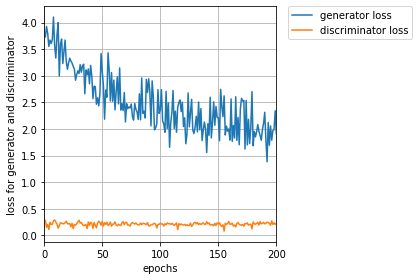

In [18]:
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(1, len(loss_gen)+1)
loss_gen = np.array(loss_gen)
loss_dis = np.array(loss_dis)
fig, axs = plt.subplots()
axs.plot(t, loss_gen, label="generator loss")
axs.plot(t, loss_dis, label="discriminator loss")
axs.set_xlim(0, 200)
axs.set_xlabel('epochs')
axs.set_ylabel('loss for generator and discriminator')
axs.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.tight_layout()
plt.show()

In [0]:
class CustomDataset(Dataset):
    def __init__(self, map_path, img_path, transform=None):
        super(CustomDataset, self).__init__()

        self.map_path = glob.glob(os.path.join(map_path, '*_mask.png'))
        
        self.img_path = [os.path.join(img_path, os.path.basename(fname)[:-9]+'_Clipped.jpg') for fname in self.map_path]

        transform_list = [transforms.ToTensor()]
        self.transform = transforms.Compose(transform_list)

    def __getitem__(self, index):
        label_map = Image.open(self.map_path[index])
        label_map = ImageOps.fit(label_map, (1024, 512), Image.NEAREST)
        label_map = label_map.convert('RGB')
        label_map = self.transform(label_map)

        img = Image.open(self.img_path[index])
        img = ImageOps.fit(img, (1024, 512), Image.NEAREST)
        img = img.convert('RGB')
        img = self.transform(img)
        
        return label_map, img
    
    def __len__(self):
        return len(self.img_path)


map_dir = 'freiburg-forest/train/GT_color/'
img_dir = 'freiburg-forest/train/rgb/'
batch_size = 1
dataset = CustomDataset(map_dir, img_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

map_dir_test = 'freiburg-forest/test/GT_color/'
img_dir_test = 'freiburg-forest/test/rgb/'
batch_size = 1
dataset_test = CustomDataset(map_dir_test, img_dir_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=1)

In [0]:
# initialization G2
learning_rate_G = 2e-5
learning_rate_D = 1e-5
train_global = False
continue_train = False

if train_global == False:
    generator_global = GlobalGenerator(3, 3)
    generator_global.load_state_dict(torch.load(global_model))
    generator = LocalEnhancer(3, 3, generator_global).to(device)
    generator_model_path = local_model
else:
    generator = GlobalGenerator(3, 3).to(device)
    generator_model_path = global_model

discriminator = MultiscaleDiscriminator(input_nc=6).to(device)

if continue_train:
    generator.load_state_dict(torch.load(generator_model_path))
    discriminator.load_state_dict(torch.load(discriminator_model_path))
elif train_global == False:
    discriminator.load_state_dict(torch.load(discriminator_model_path))

generator.train()
generator.to(device)
discriminator.train()
model = pix2pixHD(num_D=3, generator=generator, discriminator=discriminator, device=device).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_G)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate_D)

In [21]:
# local enhancer
# epoch trained: 100
num_epoch = 100
trace_freq = 10
loss_gen, loss_dis = train()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# save loss data into files
loss_gen_file = open('/content/drive/My Drive/3rd-year-project/forest-model/loss_gen.txt', 'w')
for loss in loss_gen:
	loss_gen_file.write(str(loss))
	loss_gen_file.write('\n')
loss_gen_file.close()

loss_dis_file = open('/content/drive/My Drive/3rd-year-project/forest-model/loss_dis.txt', 'w')
for loss in loss_dis:
	loss_dis_file.write(str(loss))
	loss_dis_file.write('\n')
loss_dis_file.close()

In [0]:
# initialization G2
learning_rate_G = 2e-5
learning_rate_D = 1e-5
train_global = False
continue_train = True

if train_global == False:
    generator_global = GlobalGenerator(3, 3)
    generator_global.load_state_dict(torch.load(global_model))
    generator = LocalEnhancer(3, 3, generator_global).to(device)
    generator_model_path = local_model
else:
    generator = GlobalGenerator(3, 3).to(device)
    generator_model_path = global_model

discriminator = MultiscaleDiscriminator(input_nc=6).to(device)

if continue_train:
    generator.load_state_dict(torch.load(generator_model_path))
    discriminator.load_state_dict(torch.load(discriminator_model_path))
elif train_global == False:
    discriminator.load_state_dict(torch.load(discriminator_model_path))

generator.train()
generator.to(device)
discriminator.train()
model = pix2pixHD(num_D=3, generator=generator, discriminator=discriminator, device=device).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_G)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate_D)

In [24]:
# local enhancer
# epoch trained: 150
num_epoch = 50
trace_freq = 10
loss_gen_cont, loss_dis_cont = train()

Output hidden; open in https://colab.research.google.com to view.

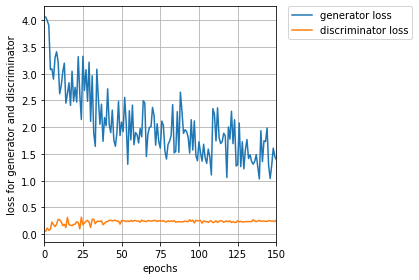

In [25]:
import numpy as np
import matplotlib.pyplot as plt

loss_gen += loss_gen_cont
loss_dis += loss_dis_cont

# save loss data into files
loss_gen_file = open('/content/drive/My Drive/3rd-year-project/forest-model/loss_gen.txt', 'w')
for loss in loss_gen:
	loss_gen_file.write(str(loss))
	loss_gen_file.write('\n')
loss_gen_file.close()

loss_dis_file = open('/content/drive/My Drive/3rd-year-project/forest-model/loss_dis.txt', 'w')
for loss in loss_dis:
	loss_dis_file.write(str(loss))
	loss_dis_file.write('\n')
loss_dis_file.close()

t = np.arange(1, len(loss_gen)+1)
loss_gen = np.array(loss_gen)
loss_dis = np.array(loss_dis)
fig, axs = plt.subplots()
axs.plot(t, loss_gen, label="generator loss")
axs.plot(t, loss_dis, label="discriminator loss")
axs.set_xlim(0, 150)
axs.set_xlabel('epochs')
axs.set_ylabel('loss for generator and discriminator')
axs.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.tight_layout()
plt.show()